In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.9 MB/s eta 0:00:00


In [3]:
tokenizer_name = "monologg/koelectra-small-v2-distilled-korquad-384"
model_name = "monologg/koelectra-small-v2-distilled-korquad-384"

In [4]:
import json
import random

import torch
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW

In [5]:
with open("/content/drive/MyDrive/WARNING_PRIVATE_FOLDER/goorm_nlp_8th_group3/goorm_nlp_8th_group3/project2/train.json", 'rb') as f:
    input_dict = json.load(f)
input_dict["data"][0]

{'title': '제주도 장마 시작 … 중부는 이달 말부터',
 'paragraphs': [{'context': '올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다.',
   'qas': [{'question': '북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?',
     'answers': [{'text': '한 달가량', 'answer_start': 478},
      {'text': '한 달', 'answer_start': 478}],
     'guid': '798db07f0b9046759deed9d4a

In [6]:
input_dict["data"][1]

{'title': '부산정보산업진흥원, 과기부 지역SW서비스사업화 지원사업 4개 과제 선정',
 'paragraphs': [{'context': '부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스사업화 지원사업’ 공모사업에 4개 과제가 선정되어 본격적인 사업 착수에 나선다. 과학기술정보통신부가 주관하는 ‘지역SW서비스사업화 지원사업’은 강소SW기업 및 초기 스타트업의 SW서비스 사업화 지원과 신시장 진출 지원을 통해 기업 경쟁력 강화와 지역경제 활성화를 도모하는 사업이다. 올해부터 2개년으로 진행되며, 국비와 시비, 민자 등 2년간 약 37억원의 예산이 투입된다. 앞서 진흥원은 부산의 미래 먹거리산업인 스마트해양, 지능형기계, 지능정보서비스 분야로 사전 수요조사를 진행했고, 평가를 통해 선정된 5개 과제를 공모사업에 신청했다. 그 결과 부산의 4개 과제가 최종 선정되는 쾌거를 거뒀다. 당 사업은 전국 진흥기관을 대상으로 공모를 시작해, 총 17개 지역에서 42개 과제가 선정되었으며, 4개 과제가 선정된 곳은 부산과 강원지역 뿐이다. 금번 선정된 과제들은 ‘인공지능융합센서와 서보 이송 로봇을 이용한 전단보강재의 자동용접시스템 개발’ 등 총 4개 과제다. 부산시가 지원하고, 부산정보산업진흥원과 지역기업, 대학, 연구소 등이 컨소시엄을 구성하여 기술개발 및 사업화 지원을 추진한다. 2개의 Track으로 구분되는 이번사업은 Track 1(SW중소기업)에서 ㈜에이아이플랫폼, 엔컴(주), Track 2(스타트업)에서는 ㈜토즈, 삼보테크놀로지를 지원한다. ○ ‘Track 1‘의 (주)에이아이플랫폼이 주관기업으로 진행하는 <인공지능 기반 망막 내 아밀로이드 플라크 영상 분석을 통한 치매조기진단 플랫폼 상용화>는 치매 확진의 원인이 되는 중요 단백질(아밀로이드 플라크)을 자체개발 관측장비로 진단한다. 이를 통해 치매를 조기 발견하여, 각종 경제적 비용과 치료 및 예방 등 사회적 문제를 해 결하고 시민들이 쉽게 접근 가능한 실효성 있는 치매관리

In [7]:
from copy import deepcopy
def split_input_dict(input_dict, ratio = 0.1, seed = 42):
    split_point = int(len(input_dict['data']) * ratio)
    random.seed(seed)
    random.shuffle(input_dict['data'])
    valid_dict = deepcopy(input_dict)
    train_dict = input_dict

    valid_dict['data'] = input_dict['data'][:split_point]
    train_dict['data'] = input_dict['data'][split_point:]
    return train_dict, valid_dict

In [8]:
def read_input(path):
    with open(path, 'rb') as f:
        input_dict = json.load(f)
    train_dict,valid_dict =split_input_dict(input_dict)
    train_contexts = []
    train_questions = []
    train_answers = []
    for group in tqdm(train_dict['data']):       #딕셔너리 하나씩 꺼낸다.
        for passage in group['paragraphs']:     #딕셔너리의 paragraphs
            context = passage['context']        #paragraphs의 context
            for qa in passage['qas']:           #paragraphs의 qas
                question = qa['question']       #paragraphs의 question
                for answer in qa['answers']:    #question의 answers
                    ### context 넘겨서 자르기 ###
                    target_context = context
                    if answer['answer_start'] > 1400:
                        target_context = target_context[1200:]
                        answer['answer_start'] -= 1200 
                    elif answer['answer_start'] > 1200:
                        target_context = target_context[1000:]
                        answer['answer_start'] -= 1000
                    elif answer['answer_start'] > 1000:
                        target_context = target_context[800:]
                        answer['answer_start'] -= 800
                    elif answer['answer_start'] > 800:
                        target_context = target_context[600:]
                        answer['answer_start'] -= 600
                    
                    train_contexts.append(target_context)    #answers의 한 answer당 해당하는 context 저장
                    ### context 넘겨서 자르기 ###
                    train_questions.append(question)  #answers의 한 answer당 해당하는 question 저장
                    train_answers.append(answer)      #answers의 한 answer 저장
  
    valid_contexts = []
    valid_questions = []
    valid_answers = []
    for group in tqdm(valid_dict['data']):       #딕셔너리 하나씩 꺼낸다.
        for passage in group['paragraphs']:     #딕셔너리의 paragraphs
            context = passage['context']        #paragraphs의 context
            for qa in passage['qas']:           #paragraphs의 qas
                question = qa['question']       #paragraphs의 question
                for answer in qa['answers']:    #question의 answers
                    ### context 넘겨서 자르기 ###
                    target_context = context
                    if answer['answer_start'] > 1400:
                        target_context = target_context[1200:]
                        answer['answer_start'] -= 1200 
                    elif answer['answer_start'] > 1200:
                        target_context = target_context[1000:]
                        answer['answer_start'] -= 1000
                    elif answer['answer_start'] > 1000:
                        target_context = target_context[800:]
                        answer['answer_start'] -= 800
                    elif answer['answer_start'] > 800:
                        target_context = target_context[600:]
                        answer['answer_start'] -= 600
                    
                    valid_contexts.append(target_context)    #answers의 한 answer당 해당하는 context 저장
                    ### context 넘겨서 자르기 ###
                    valid_questions.append(question)  #answers의 한 answer당 해당하는 question 저장
                    valid_answers.append(answer)      #answers의 한 answer 저장
    return train_contexts, train_questions, train_answers, valid_contexts, valid_questions, valid_answers

In [9]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            print("there is an unitended error in dataset") #이렇게까지 할 필요가 있나?
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1
        elif context[start_idx-2:end_idx-2] == gold_text:
            print("there is an unitended error in dataset")
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2

In [10]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [11]:
question = "북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?"
context = "올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다."
tokenizer(context, question)

{'input_ids': [2, 156, 18876, 8381, 29956, 550, 29982, 2757, 29951, 29962, 392, 30201, 29948, 5, 188, 55, 4473, 4660, 29961, 8674, 29997, 29948, 23326, 30672, 455, 1821, 29961, 6, 30124, 103, 30277, 8381, 29956, 392, 30292, 627, 29947, 29948, 5, 550, 29982, 5337, 29951, 541, 30013, 2757, 4613, 23905, 29951, 24, 29950, 8381, 9972, 29953, 814, 9563, 17196, 2757, 12364, 298, 7418, 16239, 29951, 10954, 21036, 29956, 1358, 29954, 13956, 3196, 29951, 1, 7532, 29959, 29950, 204, 29961, 97, 29956, 2708, 29948, 5, 881, 29953, 8381, 29950, 10062, 29997, 29948, 28, 260, 57, 29982, 18, 136, 29973, 29997, 1312, 989, 5046, 392, 30201, 29948, 5, 8381, 29950, 15024, 29948, 30207, 29957, 299, 10299, 27674, 29990, 14, 30833, 278, 30425, 29957, 84, 30128, 27805, 29973, 27674, 29947, 1028, 2158, 30078, 29950, 8381, 9972, 29951, 29962, 2185, 29950, 97, 29965, 913, 1086, 5, 8381, 9972, 29961, 462, 29982, 2757, 943, 4613, 3306, 9563, 11560, 2883, 90, 29982, 30277, 548, 18521, 29973, 1583, 14726, 30108, 29954

In [12]:
class KlueDataset(Dataset):
    def __init__(self, contexts, questions, answers, model_max_position_embedings, tokenizer):
        self.tokenizer = tokenizer
        self.answers = answers
        self.questions = questions
        self.contexts = contexts
        self.model_max_position_embedings = model_max_position_embedings
        print("Tokenizing ...")
        self.encodings = self.tokenizer(self.contexts, 
                                        self.questions,
                                        max_length=512, #512 truncation
                                        truncation=True,
                                        padding="max_length",
                                        return_token_type_ids=False)
        print("Done !!!")
        self.add_token_positions()
        
    def add_token_positions(self):
        start_positions = []
        end_positions = []
        for i in range(len(self.answers)):
            start_positions.append(self.encodings.char_to_token(i, self.answers[i]['answer_start']))
            end_positions.append(self.encodings.char_to_token(i, self.answers[i]['answer_end'] - 1)) # -1으로 : 진짜로 답이 있는 end_position 의 인덱스를 구함.(char_to_token은 인덱스를 구함)
            #https://huggingface.co/docs/tokenizers/v0.13.2/en/api/encoding#tokenizers.Encoding.char_to_token

            # positions 값이 None 값이라면, answer가 포함된 context가 잘렸다는 의미
            if start_positions[-1] is None:
                print("there is an error 1")
                start_positions[-1] = self.model_max_position_embedings
            if end_positions[-1] is None:
                print("there is an error 2")
                end_positions[-1] = self.model_max_position_embedings

        self.encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

        
    def get_data(self):
        return {"contexts":self.contexts, 'questions':self.questions, 'answers':self.answers}
    
    
    def get_encodings(self):
        return self.encodings
        
    
    def __getitem__(self, idx):
        return {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    
    def __len__(self):
        return len(self.encodings['input_ids'])

In [13]:
train_contexts, train_questions, train_answers, valid_contexts, valid_questions, valid_answers = read_input("/content/drive/MyDrive/WARNING_PRIVATE_FOLDER/goorm_nlp_8th_group3/goorm_nlp_8th_group3/project2/train.json")
add_end_idx(train_answers, train_contexts)                                                      #anwer 마다 answer_end 달아준다.
train_dataset = KlueDataset(train_contexts, train_questions, train_answers, 512, tokenizer)

add_end_idx(valid_answers, valid_contexts)                                                      #anwer 마다 answer_end 달아준다.
valid_dataset = KlueDataset(valid_contexts, valid_questions, valid_answers, 512, tokenizer)

  0%|          | 0/8811 [00:00<?, ?it/s]

  0%|          | 0/978 [00:00<?, ?it/s]

Tokenizing ...
Done !!!
there is an error 2
Tokenizing ...
Done !!!


In [14]:
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

Downloading:   0%|          | 0.00/54.8M [00:00<?, ?B/s]

In [15]:
EPOCH = 3
LEARNING_RATE = 5e-5
BATCH_SIZE = 32

In [25]:
import torch.nn.functional as F
loss_arr = []
lossy_arr = []
def train_runner(model, train_dataset, valid_dataset , batch_size, num_train_epochs, learning_rate):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    model.to(device)
    model.train()
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)
    valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = batch_size)

    lowest_total_valid_loss = 9999.
    lowest_total_valid_lossy = 9999.
    global_total_step = len(train_dataloader) * num_train_epochs
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0)
    print("TRAIN START")
    with tqdm(total=global_total_step, unit='step') as t:
        total = 0
        total_loss = 0
        for epoch in range(num_train_epochs):
            for iteration,batch in enumerate(train_dataloader):
                optimizer.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                start_positions = batch['start_positions'].to(device)
                end_positions = batch['end_positions'].to(device)
                outputs = model(input_ids,
                             attention_mask=attention_mask,
                             start_positions=start_positions,
                             end_positions=end_positions)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                
                batch_loss = loss.item() * len(input_ids)
                total += len(input_ids)
                total_loss += batch_loss
                global_total_step += 1
                t.set_postfix(loss="{:.6f}".format(total_loss / total), batch_loss="{:.6f}".format(batch_loss))
                t.update(1)
                
                del input_ids
                del attention_mask
                del start_positions
                del end_positions
                del outputs
                del loss

                ## validation ##
                if iteration != 0 and iteration % int(len(train_dataloader) / 50) == 0:
                    total_valid_loss = 0
                    total_valid_lossy = 0
                    for batch_val in valid_dataloader:
                        model.eval()
                        optimizer.zero_grad()

                        input_ids = batch_val['input_ids'].to(device)
                        attention_mask = batch_val['attention_mask'].to(device)
                        start_positions = batch_val['start_positions'].to(device)
                        end_positions = batch_val['end_positions'].to(device)
                
                        with torch.no_grad():
                            outputs = model(input_ids,
                                    attention_mask=attention_mask,
                                    start_positions=start_positions,
                                    end_positions=end_positions)
                            loss = outputs.loss
                            total_valid_loss += loss.item()
                            lossy = F.cross_entropy(outputs.start_logits, start_positions) + F.cross_entropy(outputs.end_logits, end_positions)
                            total_valid_lossy += lossy.item()
                    print(total_valid_loss,total_valid_lossy)
                    loss_arr.append(total_valid_loss)
                    lossy_arr.append(total_valid_lossy) 
                    if total_valid_loss < lowest_total_valid_loss:
                        print(f"lowest_total_valid_loss: {total_valid_loss} epoch : {epoch} iteration : {iteration}")
                        torch.save(model.state_dict(),'./output_model_best')
                        lowest_total_valid_loss = total_valid_loss
                ## validation ##

    #model.save_pretrained("./klue_output_model")
    print("TRAIN END")

In [26]:
train_runner(model,train_dataset,valid_dataset, BATCH_SIZE, EPOCH, LEARNING_RATE)

TRAIN START


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1491 [00:00<?, ?step/s]

163.96677207946777 327.93354415893555
lowest_total_valid_loss: 163.96677207946777 epoch : 0 iteration : 9
144.03617930412292 288.07235860824585
lowest_total_valid_loss: 144.03617930412292 epoch : 0 iteration : 18
134.74945986270905 269.4989197254181
lowest_total_valid_loss: 134.74945986270905 epoch : 0 iteration : 27
130.92076635360718 261.84153270721436
lowest_total_valid_loss: 130.92076635360718 epoch : 0 iteration : 36
127.84333527088165 255.6866705417633
lowest_total_valid_loss: 127.84333527088165 epoch : 0 iteration : 45
123.47919714450836 246.95839428901672
lowest_total_valid_loss: 123.47919714450836 epoch : 0 iteration : 54
120.97263932228088 241.94527864456177
lowest_total_valid_loss: 120.97263932228088 epoch : 0 iteration : 63
119.91393911838531 239.82787823677063
lowest_total_valid_loss: 119.91393911838531 epoch : 0 iteration : 72
120.42366051673889 240.84732103347778
118.62142217159271 237.24284434318542
lowest_total_valid_loss: 118.62142217159271 epoch : 0 iteration : 90
11

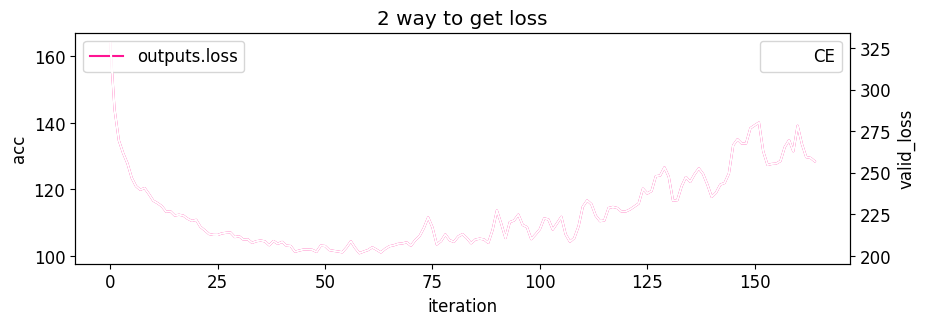

In [31]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 3)
plt.rcParams['font.size'] = 12

x = range(len(loss_arr))
y1 = loss_arr
y2 = lossy_arr

fig, ax1 = plt.subplots()
ax1.set_xlabel('iteration')
ax1.set_ylabel('acc')
ax1.plot(x, y1, color='deeppink',label='outputs.loss')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('valid_loss')
ax2.plot(x, y2, color='white',label='CE')
ax2.legend(loc='upper right')

plt.title("2 way to get loss")

plt.show()

In [ ]:
def read_dev_klue(path):
    with open(path, 'rb') as f:
        klue_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    guids = []

    for group in tqdm(klue_dict['data']):
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                guid = qa['guid']
                #temp_answer = []
                #for answer in qa['answers']:
                    #temp_answer.append(answer['text'])
                #if len(temp_answer) != 0: # answers의 길이가 0 == 답변할 수 없는 질문
                    #contexts.append(context)
                    #questions.append(question)
                    #answers.append(temp_answer)
                contexts.append(context)##
                questions.append(question)##
                guids.append(guid)

    #return contexts, questions, answers
    return contexts, questions , guids

In [ ]:
#dev_contexts, dev_questions, dev_answers = read_dev_klue("/content/drive/MyDrive/WARNING_PRIVATE_FOLDER/goorm_nlp_8th_group3/goorm_nlp_8th_group3/project2/test.json")
dev_contexts, dev_questions, dev_guids = read_dev_klue("/content/drive/MyDrive/WARNING_PRIVATE_FOLDER/goorm_nlp_8th_group3/goorm_nlp_8th_group3/project2/test.json")

  0%|          | 0/3709 [00:00<?, ?it/s]

In [ ]:
import re
def remove_post(text):
        ''' 불필요한 기호 제거 '''
        text = text.strip()
        text = re.sub("''", "'", text)
        text = re.sub('""', '"', text)
        text = re.sub("‘‘", "‘", text)
        text = re.sub("’’", "’", text)
        text = re.sub("  ", " ", text)
        text = re.sub("#", "", text)
        return text

In [ ]:


def prediction(contexts, questions, guids):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model.load_state_dict(torch.load('./output_model_best'))
    model.to(device)
    
    model.eval()
    
    result = []
    
    with torch.no_grad():
        
        for context, question, guid in zip(contexts, questions, guids):
            encodings = tokenizer(context, question, max_length=512, truncation=True,
                                     padding="max_length", return_token_type_ids=False)
            encodings = {key: torch.tensor([val]) for key, val in encodings.items()}
            
            input_ids = encodings["input_ids"].to(device)
            attention_mask = encodings["attention_mask"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            start_logits, end_logits = outputs.start_logits, outputs.end_logits
            token_start_index, token_end_index = start_logits.argmax(dim=-1), end_logits.argmax(dim=-1)
            pred_ids = input_ids[0][token_start_index: token_end_index + 1]
            if token_start_index > token_end_index:
                #print("이상값 : ",tokenizer.decode(pred_ids))
                pred = tokenizer.decode(pred_ids)
            else:
                pred = tokenizer.decode(pred_ids)



            ### context 뒷부분 test ###
            if len(context) > 800:
                encodings = tokenizer(context[800:], question, max_length=512, truncation=True,
                                     padding="max_length", return_token_type_ids=False)
                encodings = {key: torch.tensor([val]) for key, val in encodings.items()}
            
                input_ids = encodings["input_ids"].to(device)
                attention_mask = encodings["attention_mask"].to(device)
            
                outputs = model(input_ids, attention_mask=attention_mask)
                start_logits2, end_logits2 = outputs.start_logits, outputs.end_logits
            
                token_start_index, token_end_index = start_logits2.argmax(dim=-1), end_logits2.argmax(dim=-1)
                pred_ids = input_ids[0][token_start_index: token_end_index + 1]
                pred2 = tokenizer.decode(pred_ids)
                if len(pred) == 0 or max(start_logits[0]) + max(end_logits[0]) < max(start_logits2[0]) + max(end_logits2[0]):
                    pred = pred2

                

            ### context 뒷부분 test ###


            pred = pred[:10] 
            pred = remove_post(pred)

            tp = (guid,pred)
            
            result.append(tp)
    return result

In [ ]:
pred_answers = prediction(dev_contexts, dev_questions, dev_guids)
pred_answers

[('d14cb73158624cf094c546d856fd3c80', '뉴 740Li 25'),
 ('906631384e91493ebe1c7f34aea6f241', '스페인 바르셀로나'),
 ('35e61dcb479643448a2cb7d326ae50a6', '페이스북'),
 ('075e761b370040cb9041eecd39afc27c', '페이스북'),
 ('e67ed38f3dd944be94d5b4c53731f334', '마드리드'),
 ('80cacfdfe76442b0b39568e8b193d066', '판매 중단'),
 ('78a80cca941c46379a5c65b2f1392f7c', '5조원'),
 ('5c19b9781f8a4f0faa9045274c38a8b4', '운영허가 인증서'),
 ('d2844b7141cb4a2594d433e9c1e5cd0c', '오르가노폴리실록산은'),
 ('be39b91f52a04b0aaafc96ff505cb2fc', '노르웨이'),
 ('98fe72c173f642e29f9284f1769fd4f6', ''),
 ('1756f8a643124b52aa773a0f38b7b6fa', '필리핀'),
 ('1f1ef695105049079e093bae6f4ad8e7', '김교성'),
 ('acbc4be5f9d04b76a30451f8c6baf277', '79달러'),
 ('393657048abd435b9059b00ed54dcc47', '존 위클리프'),
 ('08ee8dae9f6744cf91d79e0782426d33', '존 위클리프'),
 ('0fd8aca8b9844e3d85e0379272600e3b', '지기스문트'),
 ('fa773f05fd224cbab0327d1459e38f8a', '복정역'),
 ('89810801a2f446ef9ea0b74cdc478f3c', '한울'),
 ('30a8f6b62fa142209b241d35e308002b', '서울대 음대'),
 ('4957b7070c3a463aaac97f0255ed0ab0', '로사

In [ ]:
import csv
f = open('monologg_koelectra-small-v2-distilled-korquad-384_32batch_10trucation_pre_postprocessing.csv','w', newline='')
wr = csv.writer(f)
wr.writerow(['Id','Predicted'])

for tp in pred_answers:
    wr.writerow([tp[0],tp[1]])

f.close()